# Is the initial Mtb load correlated to growth

Using the ground-truth checked tracks from the control (3,5) example.

In [22]:
import os
import btrack
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from macrohet import dataio, tools
from tqdm.auto import tqdm
from scipy import stats
colors = sns.set_palette('PiYG')

### Load metadata

In [3]:
# base_dir = '/mnt/DATA/macrohet/'
base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/PS0000/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
# metadata
metadata_path = os.path.join(base_dir, 'macrohet_images/PS0000/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Load all tracks

In [7]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/05/31 01:04:23 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/05/31 01:04:23 PM] Loading tracks/obj_type_1
[INFO][2023/05/31 01:04:23 PM] Loading LBEP/obj_type_1
[INFO][2023/05/31 01:04:23 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/05/31 01:04:24 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/05/31 01:04:24 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/05/31 01:04:24 PM] Loading tracks/obj_type_1
[INFO][2023/05/31 01:04:24 PM] Loading LBEP/obj_type_1
[INFO][2023/05/31 01:04:24 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/05/31 01:04:24 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/05/31 01:04:24 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/05/31 01:04:24 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/05/31 01:04:40 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/05/31 01:04:40 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/05/31 01:04:40 PM] Loading tracks/obj_type_1
[INFO][2023/05/31 01:04:40 PM] Loading LBEP/obj_type_1
[INFO][2023/05/31 01:04:40 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/05/31 01:04:40 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/05/31 01:04:40 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/05/31 01:04:40 PM] Loading tracks/obj_type_1
[INFO][2023/05/31 01:04:40 PM] Loading LBEP/obj_type_1
[INFO][2023/05/31 01:04:40 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/05/31 01:04:41 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/05/31 01:04:41 PM] Opening HDF file: /mnt/DATA/macrohe

### Pick set of tracks of interest

In [9]:
row, column = 3, 5
tracks = tracks_dict[(row, column)]

### Load ground truth labels for tracks

In [13]:
gt_track_dict_fn = '/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/ground_truth_tracks/(3, 5)_track_assessment.json'
# Load the JSON data from the file
with open(gt_track_dict_fn, 'r') as file:
    gt_track_dict = json.load(file)

In [12]:
gt_track_dict

{'425': True,
 '694': True,
 '403': False,
 '427': True,
 '453': False,
 '217': True,
 '1002': False,
 '1893': False,
 '1986': False,
 '2192': False,
 '401': True,
 '412': False,
 '2499': False,
 '1446': False,
 '1003': True,
 '790': False,
 '1552': False,
 '2862': False,
 '432': True,
 '456': True,
 '461': True,
 '416': True,
 '1892': False,
 '430': True,
 '1226': True,
 '1783': True,
 '429,2818': 'Link',
 '431': True,
 '407': True,
 '2675,404': 'Link',
 '398': True,
 '423': True,
 '424': True,
 '428': False,
 '418': False,
 '411': False,
 '411,1683': 'Link',
 '1058': False,
 '466': True,
 '465': True,
 '397': True,
 '426': True,
 '419': True,
 '1735': True,
 '420': True,
 '421': True,
 '802': True,
 '455': False,
 '406': False,
 '410': True,
 '411,1118': 'Link',
 '1118': True,
 '1114,2130': 'Link',
 '414': True,
 '459': True,
 '2234': True,
 '470': True,
 '437': True,
 '1649,2453': 'Link',
 '2453,3126': 'Link',
 '444': True,
 '865': False,
 '441': True,
 '318': False,
 '2952': False,

In [16]:
true_IDs = [int(ID) for ID, status in gt_track_dict.items() if status is True]

### Filter true tracks

In [18]:
true_tracks = [t for t in tracks if t.ID in true_IDs]

In [19]:
true_tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,major_axis_length,mean_intensity,orientation,area,minor_axis_length,Infected
0,423,0,723.909912,33.010132,0.000000,423,423,5,0,False,344.046997,"(3,) array",-0.105442,23203.0,87.624420,1.0
1,423,1,727.771362,38.211437,0.000000,423,423,5,0,False,410.356964,"(3,) array",-0.105384,25659.0,95.545296,1.0
2,423,2,730.887634,26.283424,0.000000,423,423,5,0,False,281.636444,"(3,) array",-0.172310,19483.0,89.392372,1.0
3,423,3,732.147583,27.895367,0.000000,423,423,5,0,False,325.991333,"(3,) array",-0.172292,22840.0,92.556488,1.0
4,423,4,730.891357,33.019173,0.000000,423,423,5,0,False,373.707001,"(3,) array",-0.152742,23224.0,80.582886,1.0
5,423,5,731.606384,30.630995,0.000000,423,423,5,0,False,351.986481,"(3,) array",-0.151112,21159.0,78.869858,1.0
6,423,6,732.788086,30.744682,0.000000,423,423,5,0,False,358.099487,"(3,) array",-0.169930,21750.0,79.728958,1.0
7,423,7,733.528625,27.149408,0.000000,423,423,5,0,False,294.958893,"(3,) array",-0.195798,15457.0,67.987579,0.0
8,423,8,733.524414,32.480957,0.000000,423,423,5,0,False,385.717529,"(3,) array",-0.201907,21431.0,73.575928,1.0
9,423,9,735.238953,29.900726,0.000000,423,423,5,0,False,409.529633,"(3,) array",-0.251289,22385.0,79.070381,1.0


### add all this information to cumulative df

In [20]:
assay_layout.loc[(3,5)]

Strain               WT
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 5), dtype: object

In [116]:
### list of track info dfs
dfs = list()
### iterate over full length tracks
for track in tqdm(true_tracks):
    ### get info for assay layout
    info = assay_layout.loc[(3,5)]
    ### compile single track dictionary of info
    d = {'Time (hours)':track['t'], 
         'x':track['x'],
         'y':track['y'],
         'x scaled':[track['x'][i]*5.04 for i, x in enumerate(track['x'])],
         'y scaled':[track['y'][i]*5.04 for i, y in enumerate(track['y'])],
         'Infection status':['Infected' if track['Infected'][i] == 1 else 'Uninfected' for i in range(len(track['Infected']))],
         'Initial infection status':['Infected' if track['Infected'][0] == 1 else 'Uninfected' for i in range(len(track['Infected']))], 
         'Final infection status':['Infected' if track['Infected'][-1] == 1 else 'Uninfected' for i in range(len(track['Infected']))], 
         'Area':track['area'], 
         'Intracellular mean Mtb content':track['mean_intensity'][:, 1],
         'Intracellular thresholded Mtb content':track['mean_intensity'][:, 2],
         'Macroph. GFP expression':track['mean_intensity'][:, 0],
         'delta Mtb': [track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2] for i in range(len(track['t']))],
         'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
         'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
         'MSD': [tools.euc_dist(track['x'][i-1], 
                                track['y'][i-1], 
                                track['x'][i], 
                                track['y'][i]) 
                  if i != 0 else 0
                  for i in range(0, len(track))],
         'Strain':[info['Strain'] for i in range(len(track['t']))], 
         'Compound':[info['Compound'] for i in range(len(track['t']))], 
         'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
         'Cell ID':[track.ID for i in range(len(track['t']))],
         'Acquisition ID':[key for i in range(len(track['t']))], 
         'Unique ID': [f'{track.ID}.{row}.{column}' for i in range(len(track['t']))]}
    ### append df to list of dfs
    dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

  0%|          | 0/384 [00:00<?, ?it/s]

/tmp/ipykernel_802743/1442386925.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
/tmp/ipykernel_802743/1442386925.py:21: RuntimeWarning: invalid value encountered in double_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
/tmp/ipykernel_802743/1442386925.py:21: RuntimeWarning: invalid value encountered in float_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
/tmp/ipykernel_802743/1442386925.py:21: RuntimeWarning: divide by zero encountered in float_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb,delta Mtb (fold-change),Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,723.909912,33.010132,3648.505957,166.371064,Infected,Infected,Infected,23203.0,357.706421,...,26.188255,5.631984,0.967023,0.000000,WT,CTRL,EC0,423,1719,423.3.5
1,1,727.771362,38.211437,3667.967666,192.585644,Infected,Infected,Infected,25659.0,363.283356,...,26.188255,5.631984,0.972516,6.477992,WT,CTRL,EC0,423,1719,423.3.5
2,2,730.887634,26.283424,3683.673677,132.468459,Infected,Infected,Infected,19483.0,355.947845,...,26.188255,5.631984,0.948291,12.328367,WT,CTRL,EC0,423,1719,423.3.5
3,3,732.147583,27.895367,3690.023818,140.592648,Infected,Infected,Infected,22840.0,354.730682,...,26.188255,5.631984,0.958847,2.045930,WT,CTRL,EC0,423,1719,423.3.5
4,4,730.891357,33.019173,3683.692441,166.416630,Infected,Infected,Infected,23224.0,356.257538,...,26.188255,5.631984,0.976475,5.275556,WT,CTRL,EC0,423,1719,423.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22813,70,11.404111,928.200378,57.476719,4678.129907,Infected,Uninfected,Infected,15506.0,437.055450,...,94.672058,inf,0.863828,2.616289,WT,CTRL,EC0,3380,1719,3380.3.5
22814,71,6.907405,927.155212,34.813321,4672.862271,Uninfected,Uninfected,Infected,5796.0,342.371277,...,94.672058,inf,0.853696,4.616572,WT,CTRL,EC0,3380,1719,3380.3.5
22815,72,9.546013,927.389832,48.111905,4674.044751,Infected,Uninfected,Infected,12314.0,399.863647,...,94.672058,inf,0.866145,2.649018,WT,CTRL,EC0,3380,1719,3380.3.5
22816,73,8.320204,924.214172,41.933827,4658.039429,Infected,Uninfected,Infected,10518.0,407.069397,...,94.672058,inf,0.803451,3.404030,WT,CTRL,EC0,3380,1719,3380.3.5


In [4]:
df = pd.read_pickle('/Users/dayn/data/macrohet_mac/sc_df_GT_70_interp.pkl')
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.346945,0.929721,0.000000,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4
1,1,459.138947,6.718642,2314.060291,33.861954,0.0,1.0,0.0,16683.0,344.687042,...,0.346945,0.977788,2.857062,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4
2,2,460.555237,10.785886,2321.198394,54.360864,0.0,1.0,0.0,18935.0,343.875061,...,0.346945,0.733415,4.306780,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4
3,3,455.878815,11.143067,2297.629226,56.161059,1.0,1.0,0.0,19937.0,345.565796,...,0.346945,0.685354,4.690043,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4
4,4,462.634186,14.050420,2331.676296,70.814116,1.0,1.0,0.0,21793.0,350.585083,...,0.346945,0.727210,7.354437,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296992,70,628.562500,1099.782104,3167.955000,5542.901807,1.0,0.0,1.0,101991.0,377.731873,...,-0.025779,0.697015,5.203749,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9
296993,71,628.463684,1102.144409,3167.456968,5554.807822,1.0,0.0,1.0,100978.0,377.812103,...,-0.025779,0.690471,2.364371,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9
296994,72,628.672058,1101.594727,3168.507173,5552.037422,1.0,0.0,1.0,108397.0,376.812805,...,-0.025779,0.665902,0.587853,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9
296995,73,630.372803,1102.817749,3177.078926,5558.201455,1.0,0.0,1.0,107079.0,377.437073,...,-0.025779,0.647429,2.094831,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9


In [5]:
N_cell_df = list()
acq_ID = (3,5)
expt_df = df
N_cells = list()
N_cells_infected = list()
N_cells_uninfected = list()
info = assay_layout.loc[acq_ID]
for t in range(0, 75):
    N_cells.append(len(expt_df[expt_df['Time (hours)'] == t]))
    N_cells_infected.append(len(expt_df[(expt_df['Time (hours)'] == t) 
                                        & (expt_df['Infection status'] == 1)]))
    N_cells_uninfected.append(len(expt_df[(expt_df['Time (hours)'] == t) 
                                        & (expt_df['Infection status'] != 1)]))

d = {'Time (hours)':list(range(0, 75)), 
     'N_cells':N_cells,
     'N_cells_infected':N_cells_infected,
     'N_cells_uninfected':N_cells_uninfected, 
     'Acquisition ID': [acq_ID for i in range(0,75)],
     'Strain':[info['Strain'] for i in range(0, 75)], 
     'Compound':[info['Compound'] for i in range(0, 75)], 
     'Concentration':[info['ConcentrationEC'] for i in  range(0, 75)], }
N_cell_df.append(pd.DataFrame(d))
### concat single track dfs into big df
N_cell_df = pd.concat(N_cell_df, ignore_index=True)
N_cell_df

,Time (hours),N_cells,N_cells_infected,N_cells_uninfected,Acquisition ID,Strain,Compound,Concentration
0,0,3461,1847,1614,"(3, 5)",WT,CTRL,EC0
1,1,3660,1917,1743,"(3, 5)",WT,CTRL,EC0
2,2,3806,2004,1802,"(3, 5)",WT,CTRL,EC0
3,3,3904,2030,1874,"(3, 5)",WT,CTRL,EC0
4,4,3953,2050,1903,"(3, 5)",WT,CTRL,EC0
...,...,...,...,...,...,...,...,...
70,70,3980,2555,1425,"(3, 5)",WT,CTRL,EC0
71,71,3942,2543,1399,"(3, 5)",WT,CTRL,EC0
72,72,3906,2529,1377,"(3, 5)",WT,CTRL,EC0
73,73,3842,2483,1359,"(3, 5)",WT,CTRL,EC0


# Plotting

In [107]:
colors = sns.color_palette('PiYG')

In [25]:
colors = sns.color_palette('PiYG')
sns.set_theme(style = 'white')
# sns.set(font='Nimbus Sans', style = 'white')

In [6]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/gt_tracks_3,5_may23'
output_dir = '/Users/dayn/data/macrohet_mac/temp_results/'#'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480/'


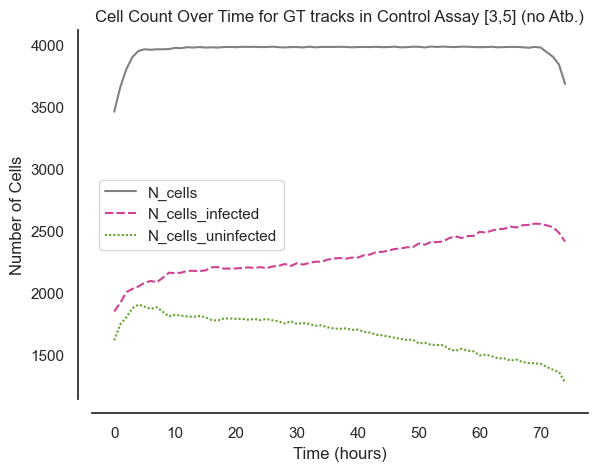

In [9]:
sns.set( style = 'white')
# Define the color palette
colors_ = {'N_cells': 'gray', 'N_cells_infected': sns.color_palette('PiYG')[0], 'N_cells_uninfected': sns.color_palette('PiYG')[-1]}
# labels = {'Total number of cells','Number of infected cells', 'Number of uninfected cells'}

# Plot the line plot with the specified colors
sns.lineplot(data=N_cell_df[['N_cells', 'N_cells_infected', 'N_cells_uninfected']], palette=colors_)

# Set labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Number of Cells')
plt.title('Cell Count Over Time for GT tracks in Control Assay [3,5] (no Atb.)')

sns.despine(offset = 10)

plt.savefig(os.path.join(output_dir, 'N_cell_infect_vs_uninfect.png'), dpi = 314, bbox_inches ='tight')

# Show the plot
plt.show()

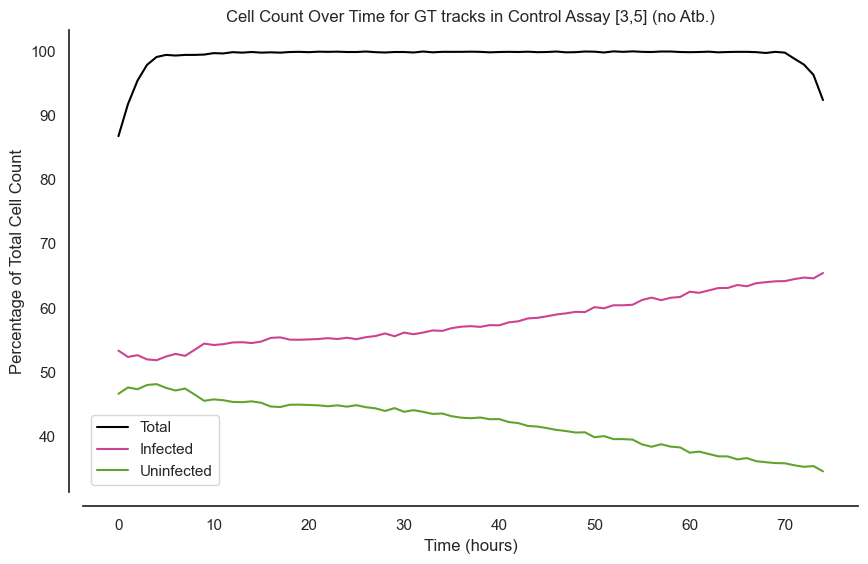

In [10]:
sns.set(font='Nimbus Sans', style='white')
sns.set(style='white')

# Define the color palette
colors_ = {'N_cells': 'gray', 'N_cells_infected': sns.color_palette('PiYG')[0], 'N_cells_uninfected': sns.color_palette('PiYG')[-1]}

# Calculate percentage values
total_cells = N_cell_df['N_cells']
infected_cells = N_cell_df['N_cells_infected']
uninfected_cells = N_cell_df['N_cells_uninfected']

total_percentage = total_cells / total_cells.max() * 100
infected_percentage = infected_cells / total_cells * 100
uninfected_percentage = uninfected_cells / total_cells * 100

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the line plot with the specified colors and percentage values
sns.lineplot(data=total_percentage, color='black', label='Total', ax=ax)
sns.lineplot(data=infected_percentage, color=sns.color_palette('PiYG')[0], label='Infected', ax=ax)
sns.lineplot(data=uninfected_percentage, color=sns.color_palette('PiYG')[-1], label='Uninfected', ax=ax)

# Set labels and title
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Percentage of Total Cell Count')
ax.set_title('Cell Count Over Time for GT tracks in Control Assay [3,5] (no Atb.)')

# Remove spines on the top and right side
sns.despine(offset=10)

# Show the legend
plt.legend()
# Show the plot
plt.savefig(os.path.join(output_dir, 'N_cell_infect_vs_uninfect_w_percent.png'), dpi=314, bbox_inches='tight')
plt.show()


In [79]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Macroph. GFP expression,delta Mtb,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,723.909912,33.010132,3648.505957,166.371064,1.0,1.0,1.0,23203.0,357.706421,...,887.426208,26.188255,0.967023,0.000000,WT,CTRL,EC0,423,1719,423.3.5
1,1,727.771362,38.211437,3667.967666,192.585644,1.0,1.0,1.0,25659.0,363.283356,...,1602.132080,26.188255,0.972516,6.477992,WT,CTRL,EC0,423,1719,423.3.5
2,2,730.887634,26.283424,3683.673677,132.468459,1.0,1.0,1.0,19483.0,355.947845,...,1095.762207,26.188255,0.948291,12.328367,WT,CTRL,EC0,423,1719,423.3.5
3,3,732.147583,27.895367,3690.023818,140.592648,1.0,1.0,1.0,22840.0,354.730682,...,953.190063,26.188255,0.958847,2.045930,WT,CTRL,EC0,423,1719,423.3.5
4,4,730.891357,33.019173,3683.692441,166.416630,1.0,1.0,1.0,23224.0,356.257538,...,995.672668,26.188255,0.976475,5.275556,WT,CTRL,EC0,423,1719,423.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22813,70,11.404111,928.200378,57.476719,4678.129907,1.0,0.0,1.0,15506.0,437.055450,...,2788.570068,94.672058,0.863828,2.616289,WT,CTRL,EC0,3380,1719,3380.3.5
22814,71,6.907405,927.155212,34.813321,4672.862271,0.0,0.0,1.0,5796.0,342.371277,...,2744.147217,94.672058,0.853696,4.616572,WT,CTRL,EC0,3380,1719,3380.3.5
22815,72,9.546013,927.389832,48.111905,4674.044751,1.0,0.0,1.0,12314.0,399.863647,...,2788.622559,94.672058,0.866145,2.649018,WT,CTRL,EC0,3380,1719,3380.3.5
22816,73,8.320204,924.214172,41.933827,4658.039429,1.0,0.0,1.0,10518.0,407.069397,...,2974.992676,94.672058,0.803451,3.404030,WT,CTRL,EC0,3380,1719,3380.3.5


In [80]:
df.keys()

Index(['Time (hours)', 'x', 'y', 'x scaled', 'y scaled', 'Infection status',
       'Initial infection status', 'Final infection status', 'Area',
       'Intracellular mean Mtb content',
       'Intracellular thresholded Mtb content', 'Macroph. GFP expression',
       'delta Mtb', 'Eccentricity', 'MSD', 'Strain', 'Compound',
       'Concentration', 'Cell ID', 'Acquisition ID', 'Unique ID'],
      dtype='object')

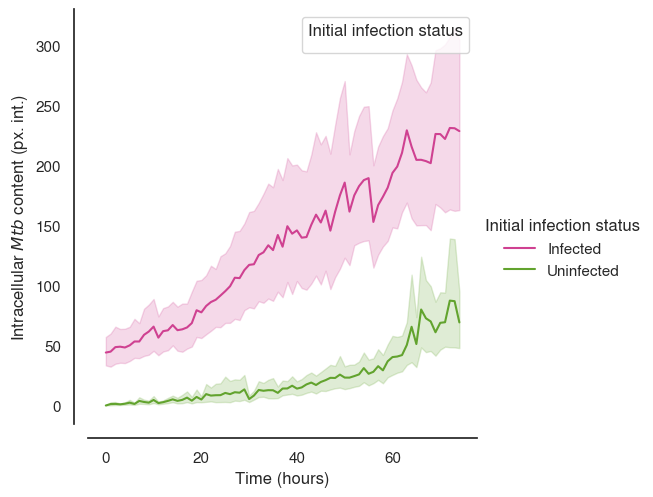

In [95]:
g = sns.relplot(data = df,
                x = 'Time (hours)', 
                y = 'Intracellular thresholded Mtb content', 
#                 style= 'Concentration',
                hue= 'Initial infection status',
#                 col= 'Compound',
                kind = 'line',
                aspect = 1,
                palette=[sns.color_palette('PiYG')[0],sns.color_palette('PiYG')[-1]] 
           )

# Get the current legend handles and labels
handles, labels = g._legend_data.values(), ['Infected', 'Uninfected']

# Set the new labels for the legend
g.ax.legend(handles, labels, title='Initial infection status')
g.set_ylabels("Intracellular $\\mathit{Mtb}$ content (px. int.)")
# g.set_ylabels("Intracellular Mtb content")
sns.despine(offset = 10)

In [15]:
df['delta Mtb'] = df['delta Mtb max fold-change normalised max area']

In [17]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,MSD,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID,dMtb,delta Mtb
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.000000,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.000586
1,1,459.138947,6.718642,2314.060291,33.861954,0.0,1.0,0.0,16683.0,344.687042,...,2.857062,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.000586
2,2,460.555237,10.785886,2321.198394,54.360864,0.0,1.0,0.0,18935.0,343.875061,...,4.306780,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.000586
3,3,455.878815,11.143067,2297.629226,56.161059,1.0,1.0,0.0,19937.0,345.565796,...,4.690043,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.000586
4,4,462.634186,14.050420,2331.676296,70.814116,1.0,1.0,0.0,21793.0,350.585083,...,7.354437,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.000586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296992,70,628.562500,1099.782104,3167.955000,5542.901807,1.0,0.0,1.0,101991.0,377.731873,...,5.203749,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,0.000030
296993,71,628.463684,1102.144409,3167.456968,5554.807822,1.0,0.0,1.0,100978.0,377.812103,...,2.364371,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,0.000030
296994,72,628.672058,1101.594727,3168.507173,5552.037422,1.0,0.0,1.0,108397.0,376.812805,...,0.587853,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,0.000030
296995,73,630.372803,1102.817749,3177.078926,5558.201455,1.0,0.0,1.0,107079.0,377.437073,...,2.094831,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,0.000030


In [24]:
colors

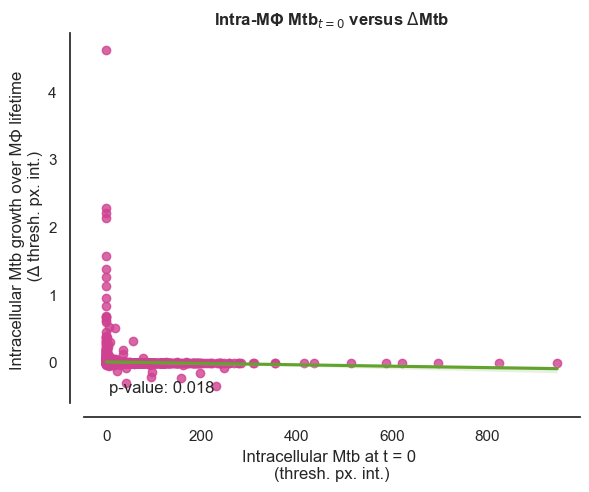

In [35]:
# Filter the DataFrame for Time (hours) == 0
subset_df = df[df['Time (hours)'] == 0][['Intracellular thresholded Mtb content', 'delta Mtb']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x='Intracellular thresholded Mtb content', 
            y='delta Mtb', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('Intracellular Mtb at t = 0 \n(thresh. px. int.)')
plt.ylabel('Intracellular Mtb growth over MΦ lifetime \n (Δ thresh. px. int.)')
plt.title("Intra-MΦ Mtb$_{t = 0}$ versus $\Delta$Mtb", fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df['delta Mtb'])

# Add the p-value to the plot
reg_plot.text(0.05, 0.02, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# plt.ylim(-50, 2600)
# # Modify y-axis tick labels to show only positive values
# plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])
os.makedirs(os.path.join(output_dir, 'initial_load_growth_correlation/'), exist_ok = True)
plt.savefig(os.path.join(output_dir, 'initial_load_growth_correlation/px_change_all_cells.png'), bbox_inches='tight', dpi = 314)

# Show the plot
plt.show()


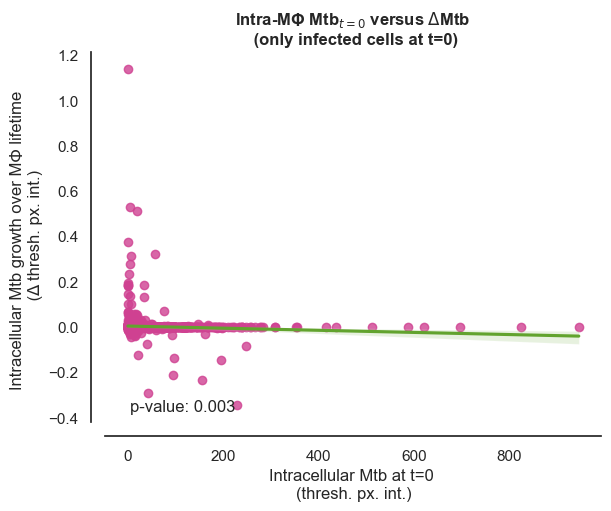

In [36]:
# Filter the DataFrame for Time (hours) == 0
subset_df = df[(df['Time (hours)'] == 0) & (df['Intracellular thresholded Mtb content'] != 0)][['Intracellular thresholded Mtb content', 'delta Mtb']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x='Intracellular thresholded Mtb content', 
            y='delta Mtb', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('Intracellular Mtb at t=0 \n(thresh. px. int.)')
plt.ylabel('Intracellular Mtb growth over MΦ lifetime \n (Δ thresh. px. int.)')
plt.title('Intra-MΦ Mtb$_{t=0}$ versus $\Delta$Mtb \n (only infected cells at t=0)', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df['delta Mtb'])

# Add the p-value to the plot
reg_plot.text(0.05, 0.02, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

plt.savefig(os.path.join(output_dir, 'initial_load_growth_correlation/px_change_infected_cells.png'), bbox_inches='tight', dpi = 314)

# Show the plot
plt.show()


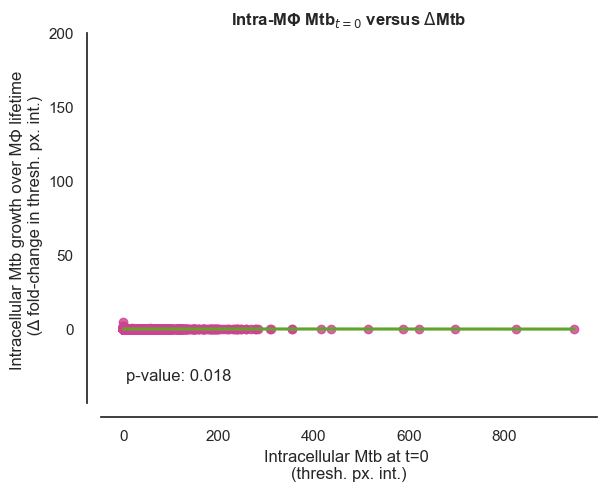

In [39]:
# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[(df['Time (hours)'] == 0)][['Intracellular thresholded Mtb content', 'delta Mtb']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x='Intracellular thresholded Mtb content', 
            y='delta Mtb', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('Intracellular Mtb at t=0 \n(thresh. px. int.)')
plt.ylabel('Intracellular Mtb growth over MΦ lifetime \n (Δ fold-change in thresh. px. int.)')
plt.title('Intra-MΦ Mtb$_{t=0}$ versus $\Delta$Mtb', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df['delta Mtb'])

# Add the p-value to the plot
reg_plot.text(0.05, 0.05, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

plt.ylim(-50, 200)
# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

plt.savefig(os.path.join(output_dir, 'initial_load_growth_correlation/fold_change_all_cells.png'), bbox_inches='tight', dpi = 314)

# Show the plot
plt.show()

In [194]:
output_dir

'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/gt_tracks_3,5_may23'

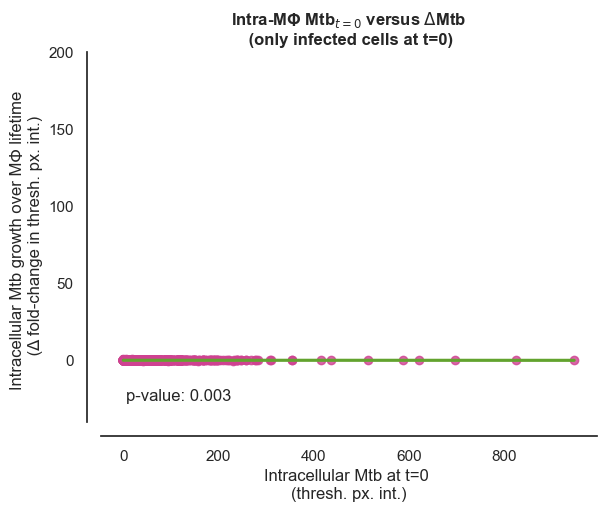

In [40]:
# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[(df['Time (hours)'] == 0) & (df['Intracellular thresholded Mtb content'] != 0)][['Intracellular thresholded Mtb content', 'delta Mtb']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x='Intracellular thresholded Mtb content', 
            y='delta Mtb', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('Intracellular Mtb at t=0 \n(thresh. px. int.)')
plt.ylabel('Intracellular Mtb growth over MΦ lifetime \n (Δ fold-change in thresh. px. int.)')
plt.title('Intra-MΦ Mtb$_{t=0}$ versus $\Delta$Mtb \n (only infected cells at t=0)', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df['delta Mtb'])

# Add the p-value to the plot
reg_plot.text(0.05, 0.05, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

plt.ylim(-40, 200)
# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

plt.savefig(os.path.join(output_dir, 'initial_load_growth_correlation/fold_change_infected_cells.png'), bbox_inches='tight', dpi = 314)

# Show the plot
plt.show()


# Initial conclusion:

Of the infected cells, there seems to be a trend that the less-infected cells are more liable to have a larger growth, which is understandable on a biological level (more space to grow?).

### What about other correlations? Area?

In [234]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb,delta Mtb (fold-change),Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,723.909912,33.010132,3648.505957,166.371064,Infected,Infected,Infected,23203.0,357.706421,...,26.188255,5.631984,0.967023,0.000000,WT,CTRL,EC0,423,1719,423.3.5
1,1,727.771362,38.211437,3667.967666,192.585644,Infected,Infected,Infected,25659.0,363.283356,...,26.188255,5.631984,0.972516,6.477992,WT,CTRL,EC0,423,1719,423.3.5
2,2,730.887634,26.283424,3683.673677,132.468459,Infected,Infected,Infected,19483.0,355.947845,...,26.188255,5.631984,0.948291,12.328367,WT,CTRL,EC0,423,1719,423.3.5
3,3,732.147583,27.895367,3690.023818,140.592648,Infected,Infected,Infected,22840.0,354.730682,...,26.188255,5.631984,0.958847,2.045930,WT,CTRL,EC0,423,1719,423.3.5
4,4,730.891357,33.019173,3683.692441,166.416630,Infected,Infected,Infected,23224.0,356.257538,...,26.188255,5.631984,0.976475,5.275556,WT,CTRL,EC0,423,1719,423.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22813,70,11.404111,928.200378,57.476719,4678.129907,Infected,Uninfected,Infected,15506.0,437.055450,...,94.672058,inf,0.863828,2.616289,WT,CTRL,EC0,3380,1719,3380.3.5
22814,71,6.907405,927.155212,34.813321,4672.862271,Uninfected,Uninfected,Infected,5796.0,342.371277,...,94.672058,inf,0.853696,4.616572,WT,CTRL,EC0,3380,1719,3380.3.5
22815,72,9.546013,927.389832,48.111905,4674.044751,Infected,Uninfected,Infected,12314.0,399.863647,...,94.672058,inf,0.866145,2.649018,WT,CTRL,EC0,3380,1719,3380.3.5
22816,73,8.320204,924.214172,41.933827,4658.039429,Infected,Uninfected,Infected,10518.0,407.069397,...,94.672058,inf,0.803451,3.404030,WT,CTRL,EC0,3380,1719,3380.3.5


In [238]:
subset_df

,Intracellular thresholded Mtb content,Area
0,4.649916,518.551366
75,3.395546,1036.722808
386,53.289265,160.082034
436,0.322617,883.568797
470,20.295877,547.537321
...,...,...
14461,4.035587,4294.167596
14709,1.924621,1162.209422
15200,4.398051,1334.895989
15544,5.526568,1269.772570


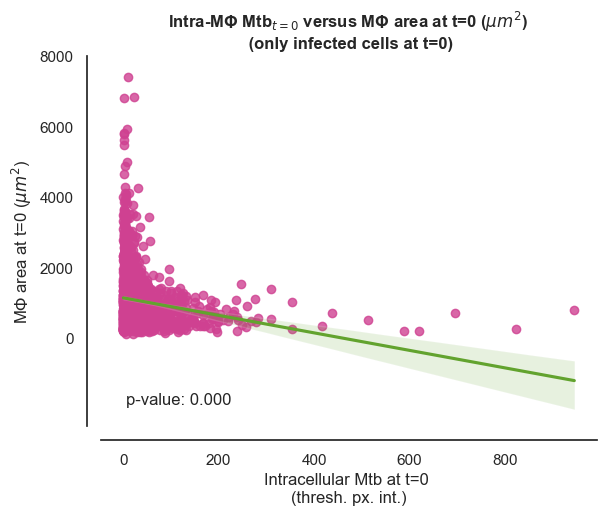

In [41]:
# Define another parameter to measure
other_param = 'Area'

# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[(df['Time (hours)'] == 0) & (df['Intracellular thresholded Mtb content'] != 0)][['Intracellular thresholded Mtb content', other_param]]

# scale area, 1m2 to 1um2 *1E6**2
scale_factor = 1.4949402023919043E-7
subset_df['Area'] = (subset_df['Area'] * scale_factor**2 ) * 1E6**2 

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x='Intracellular thresholded Mtb content', 
                       y=other_param, color=colors[0], 
                       line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('Intracellular Mtb at t=0 \n(thresh. px. int.)')
plt.ylabel('MΦ area at t=0 ($\mu {m}^2$)')
plt.title('Intra-MΦ Mtb$_{t=0}$ versus MΦ area at t=0 ($\mu {m}^2$) \n (only infected cells at t=0)', fontweight='bold')

# Remove the top and right spines
sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, 0.05, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'area_t0_Mtb_t0'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

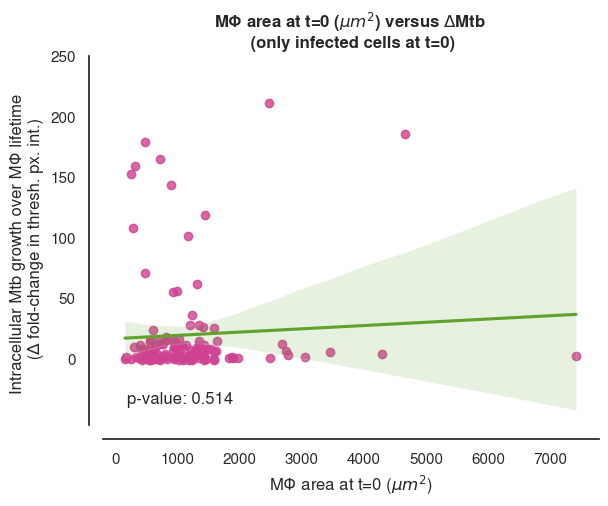

In [250]:
# Define another parameter to measure
other_param = 'Area'

# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[(df['Time (hours)'] == 0) & (df['Intracellular thresholded Mtb content'] != 0)][[other_param, 'delta Mtb (fold-change)']]


# scale area, 1m2 to 1um2 *1E6**2
scale_factor = 1.4949402023919043E-7
subset_df['Area'] = (subset_df['Area'] * scale_factor**2 ) * 1E6**2 

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x=other_param, 
            y='delta Mtb (fold-change)', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('MΦ area at t=0 ($\mu {m}^2$)')
plt.ylabel('Intracellular Mtb growth over MΦ lifetime \n (Δ fold-change in thresh. px. int.)')
plt.title('MΦ area at t=0 ($\mu {m}^2$) versus $\Delta$Mtb \n (only infected cells at t=0)', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df[other_param], subset_df['delta Mtb (fold-change)'])

# Add the p-value to the plot
reg_plot.text(0.05, 0.05, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'area_t0_vs_fold_change_mtb_infected_cells'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

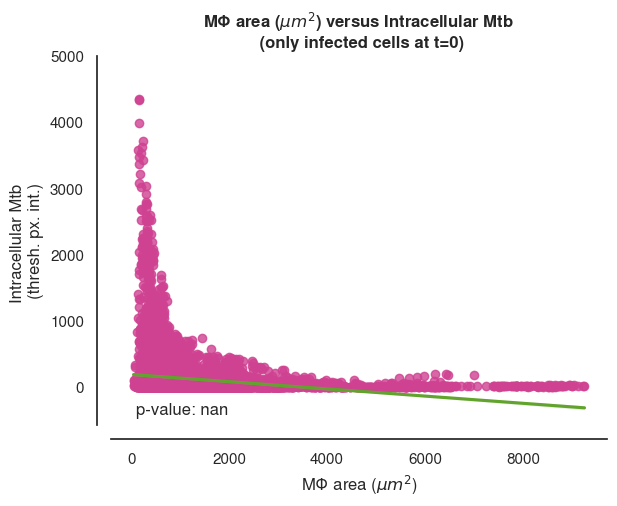

In [261]:
# Define another parameter to measure
other_param = 'Area'

# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[(df['Intracellular thresholded Mtb content'] != 0)][[other_param, 'Intracellular thresholded Mtb content']]


# scale area, 1m2 to 1um2 *1E6**2
scale_factor = 1.4949402023919043E-7
subset_df['Area'] = (subset_df['Area'] * scale_factor**2 ) * 1E6**2 

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x=other_param, 
            y='Intracellular thresholded Mtb content', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('MΦ area ($\mu {m}^2$)')
plt.ylabel('Intracellular Mtb \n(thresh. px. int.)')
plt.title('MΦ area ($\mu {m}^2$) versus Intracellular Mtb \n (only infected cells at t=0)', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, 0.02, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'area_vs_mtb_infected_cells'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

/tmp/ipykernel_802743/2566460674.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['Area'] = (subset_df['Area'] * scale_factor**2 ) * 1E6**2


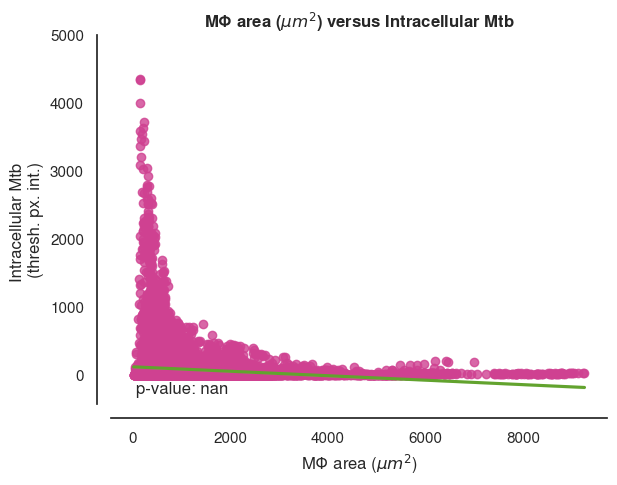

In [282]:
# Define another parameter to measure
other_param = 'Area'

# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[[other_param, 'Intracellular thresholded Mtb content']]


# scale area, 1m2 to 1um2 *1E6**2
scale_factor = 1.4949402023919043E-7
subset_df['Area'] = (subset_df['Area'] * scale_factor**2 ) * 1E6**2 

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x=other_param, 
            y='Intracellular thresholded Mtb content', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('MΦ area ($\mu {m}^2$)')
plt.ylabel('Intracellular Mtb \n(thresh. px. int.)')
plt.title('MΦ area ($\mu {m}^2$) versus Intracellular Mtb', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, 0.02, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'area_vs_mtb_all_cells'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

In [264]:
df.keys()

Index(['Time (hours)', 'x', 'y', 'x scaled', 'y scaled', 'Infection status',
       'Initial infection status', 'Final infection status', 'Area',
       'Intracellular mean Mtb content',
       'Intracellular thresholded Mtb content', 'Macroph. GFP expression',
       'delta Mtb', 'delta Mtb (fold-change)', 'Eccentricity', 'MSD', 'Strain',
       'Compound', 'Concentration', 'Cell ID', 'Acquisition ID', 'Unique ID'],
      dtype='object')

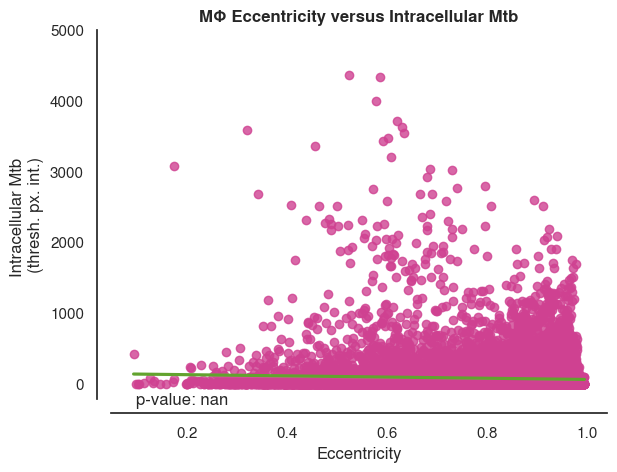

In [276]:
# Define another parameter to measure
other_param = 'Eccentricity'

# Filter the DataFrame infected cells
subset_df = df[[other_param, 'Intracellular thresholded Mtb content']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x=other_param, 
            y='Intracellular thresholded Mtb content', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel(other_param)
plt.ylabel('Intracellular Mtb \n(thresh. px. int.)')
plt.title(f'MΦ {other_param} versus Intracellular Mtb', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, -0.025, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'eccentricity_vs_mtb_all_cells'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

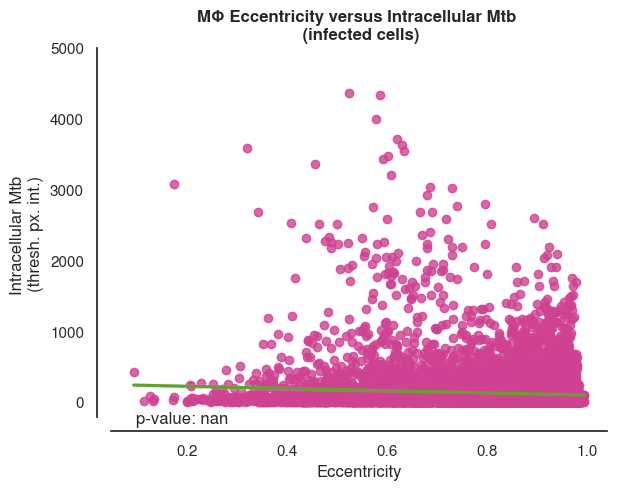

In [275]:
# Define another parameter to measure
other_param = 'Eccentricity'

# Filter the DataFrame infected cells
subset_df = df[(df['Intracellular thresholded Mtb content'] != 0)][[other_param, 'Intracellular thresholded Mtb content']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x=other_param, 
            y='Intracellular thresholded Mtb content', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel(other_param)
plt.ylabel('Intracellular Mtb \n(thresh. px. int.)')
plt.title(f'MΦ {other_param} versus Intracellular Mtb \n (infected cells)', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, -0.025, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'eccentricity_vs_mtb_infected_cells'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

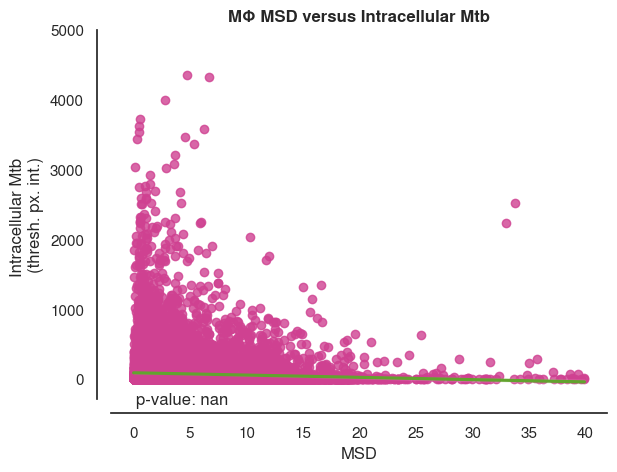

In [280]:
# Define another parameter to measure
other_param = 'MSD'

# Filter the DataFrame infected cells
subset_df = df[[other_param, 'Intracellular thresholded Mtb content']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x=other_param, 
            y='Intracellular thresholded Mtb content', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel(other_param)
plt.ylabel('Intracellular Mtb \n(thresh. px. int.)')
plt.title(f'MΦ {other_param} versus Intracellular Mtb', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, -0.025, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'MSD_vs_mtb_all_cells'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

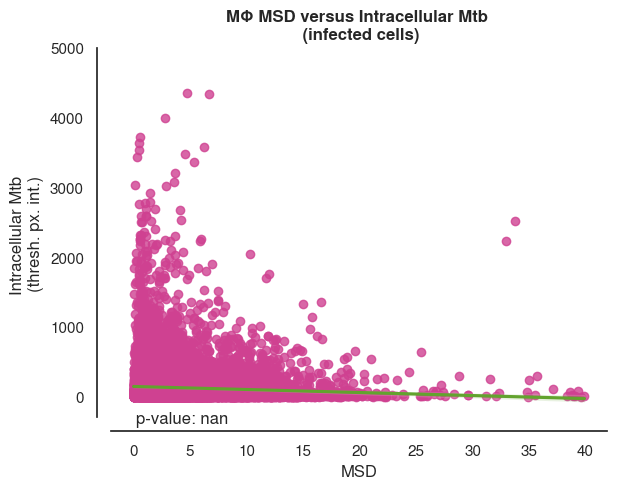

In [278]:
# Define another parameter to measure
other_param = 'MSD'

# Filter the DataFrame infected cells
subset_df = df[(df['Intracellular thresholded Mtb content'] != 0)][[other_param, 'Intracellular thresholded Mtb content']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x=other_param, 
            y='Intracellular thresholded Mtb content', color=colors[0], 
            line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel(other_param)
plt.ylabel('Intracellular Mtb \n(thresh. px. int.)')
plt.title(f'MΦ {other_param} versus Intracellular Mtb \n (infected cells)', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular thresholded Mtb content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, -0.025, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'msd_vs_mtb_infected_cells'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

In [283]:
df.keys()

Index(['Time (hours)', 'x', 'y', 'x scaled', 'y scaled', 'Infection status',
       'Initial infection status', 'Final infection status', 'Area',
       'Intracellular mean Mtb content',
       'Intracellular thresholded Mtb content', 'Macroph. GFP expression',
       'delta Mtb', 'delta Mtb (fold-change)', 'Eccentricity', 'MSD', 'Strain',
       'Compound', 'Concentration', 'Cell ID', 'Acquisition ID', 'Unique ID'],
      dtype='object')

# Gradient analysis of delta Mtb growth

In [284]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb,delta Mtb (fold-change),Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,723.909912,33.010132,3648.505957,166.371064,Infected,Infected,Infected,23203.0,357.706421,...,26.188255,5.631984,0.967023,0.000000,WT,CTRL,EC0,423,1719,423.3.5
1,1,727.771362,38.211437,3667.967666,192.585644,Infected,Infected,Infected,25659.0,363.283356,...,26.188255,5.631984,0.972516,6.477992,WT,CTRL,EC0,423,1719,423.3.5
2,2,730.887634,26.283424,3683.673677,132.468459,Infected,Infected,Infected,19483.0,355.947845,...,26.188255,5.631984,0.948291,12.328367,WT,CTRL,EC0,423,1719,423.3.5
3,3,732.147583,27.895367,3690.023818,140.592648,Infected,Infected,Infected,22840.0,354.730682,...,26.188255,5.631984,0.958847,2.045930,WT,CTRL,EC0,423,1719,423.3.5
4,4,730.891357,33.019173,3683.692441,166.416630,Infected,Infected,Infected,23224.0,356.257538,...,26.188255,5.631984,0.976475,5.275556,WT,CTRL,EC0,423,1719,423.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22813,70,11.404111,928.200378,57.476719,4678.129907,Infected,Uninfected,Infected,15506.0,437.055450,...,94.672058,inf,0.863828,2.616289,WT,CTRL,EC0,3380,1719,3380.3.5
22814,71,6.907405,927.155212,34.813321,4672.862271,Uninfected,Uninfected,Infected,5796.0,342.371277,...,94.672058,inf,0.853696,4.616572,WT,CTRL,EC0,3380,1719,3380.3.5
22815,72,9.546013,927.389832,48.111905,4674.044751,Infected,Uninfected,Infected,12314.0,399.863647,...,94.672058,inf,0.866145,2.649018,WT,CTRL,EC0,3380,1719,3380.3.5
22816,73,8.320204,924.214172,41.933827,4658.039429,Infected,Uninfected,Infected,10518.0,407.069397,...,94.672058,inf,0.803451,3.404030,WT,CTRL,EC0,3380,1719,3380.3.5


# % of cells that are permissive for growth

In [294]:
colors_

{'N_cells': 'gray',
 'N_cells_infected': (0.8129181084198386,
  0.2544405997693195,
  0.5693194925028835),
 'N_cells_uninfected': (0.38269896193771624,
  0.6403690888119954,
  0.18108419838523643)}

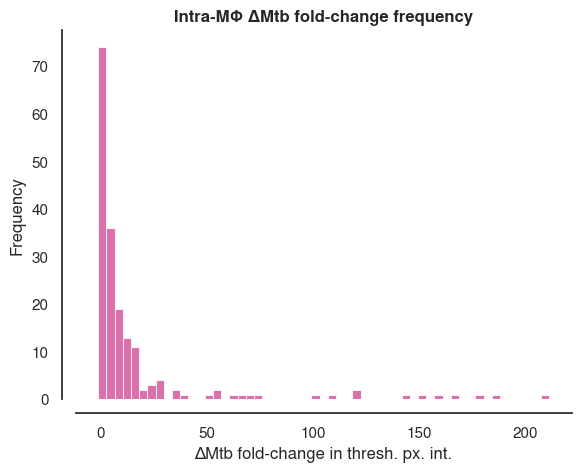

In [297]:
sns.histplot(df['delta Mtb (fold-change)'].unique(), color=(0.8129181084198386,
  0.2544405997693195,
  0.5693194925028835))

sns.despine(offset = 10)

# Set the axis labels and title
plt.xlabel('ΔMtb fold-change in thresh. px. int.')
plt.ylabel('Frequency')
plt.title(f'Intra-MΦ ΔMtb fold-change frequency', fontweight='bold')
# Define a title
fn_title = 'distribution_delta_mtb_foldchange'
# Save the plot
plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)
